# Regressão Linear, simples e múltipla

Neste análise, pretende-se a reprodução do experimento de regressão linear visto no artigo [Supervised Machine Learning for Estimation of Total Suspended Solids in Urban Watersheds](https://www.mdpi.com/2073-4441/13/2/147) de Moeini, et al. Fazemos uso do mesmo dataset indicado pelo autor mas não da mesma [ferramenta estatítica](https://orangedatamining.com/), optando pelo maior controle que o Jupyter Notebook nos oferece.

Ao final chegamos a um resultado bastante próximo àquele apresentado pelos autores, ainda que necessitamos tomar algumas decisões metodológicas onde estas não foram descritas pelos mesmos. Ressaltamos onde estas ocorrem ao longo do texto.

## Dependências

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import RegressionResults
from typing import Any, Callable
from matplotlib.axes import Axes
from functools import partial
from sklearn.model_selection import RepeatedStratifiedKFold as RSKF
from sklearn.metrics import r2_score, mean_squared_error as MSE

## Dataset

Especificamos o arquivo onde estão contidos os dados. Trata-se de um arquivo `.csv` gerado com a ferramenta LibreOffice Calc à partir do arquivo `.xlsx` citado na [referência](https://bmpdatabase.org/national-stormwater-quality-database) dos autores, conforme as seguintes especificações.

In [2]:
dataset = {
    'filepath_or_buffer': '../NSQD_v4.02_2015.csv',
    'sep': '|',
    'encoding': 'latin-1',
}

## Seleção dos parâmetros

Objetivamos estimar o valor da concentração total de sólidos suspensos em miligramas por litro (TSS mg/L) na água da chuva captada pelos sistemas de drenagem de diferentes centros urbanos nos Estados Unidos. O dataset fornecido contém uma diversidade de dados hidrológicos dos quais apenas uma parte são relevantes para esta análise. Conforme os autores, estes são:

### Fatores hidrológicos

- **Nível da chuva:** Um dos principais fatores determinantes. Chuvas mais intensas tipicamente produzem maior escoamento e possuem maior energia para desprender e transportar sedimentos.

- **Nível do escoamento:** Os sólidos suspensos são carregados pelo escoamento. O nível do escoamento combinado a área de drenagem nos permite calcular o volume do escoamento, que é um indicativo da energia disponível para carregar os sólidos

- **Dias desde a última chuva:** Maiores intervalos entre chuvas permitem maior acúmulo de detritos e sedimentos passiveis de serem desprendidos na chuva seguinte.


### Fatores de drenagem

- **Área de Drenagem**
- 
- **Ipermeabilidade do solo:** superfícies ipermeáveis são importantes contribuintes para o TSS: estes não absorvem poluentes e são um conduto pelos quais poluentes podem ser carregados ao sistema de drenagem.

### Uso da terra

O dataset descreve uma variedade de usos da terra, os quais são passíveis de impactar a concentração de detritos no solo. O autor menciona fazer uso de todos os tipos de terreno em sua análise, mas, por um método não descrito, sintetiza esta informação em uma única variável. Aqui, nós fazemos uso de todas as variáveis relacionadas ao uso da terra. Noutro experimento, tentaremos a subtituição destas variáveis pela variável [curve number](https://www.txdot.gov/content/txdotoms/us/en/manuals/des/hyd/chapter-4--hydrology/section-13--hydrograph-method/nrcs-curve-number-loss-model.html), também associada a o uso da terra.

### Contexto

- **Zona de chuva EPA:** Classificação numérica que agrupa regiões geograficas dos Estados Unidos de acordo com o comportamento da chuva.

- **Estação:** a estação climática do ano. Frequentemente esta produz alterações nos comportamentos das chuvas.

In [3]:
columns = [
    # Hydrological factors
    'Precipitation_Depth_(in)',
    'Runoff_(in)',
    'Days since last rain',

    # Drainage factors
    'Drainage_Area_Acres',
    'Percent_Impervious',

    # Land use
    'Percentage_Residential',
    'Percentage_Institutional',
    'Percentage_Commercial',
    'Percentage_Industrial',
    'Percentage_Open_Space',
    'Percentage_Freeway',
    'Percentage_Water',

    # Target
    'TSS (mg/L)',

    # Context
    'EPA_Rain_Zone',
    'Main_Type_Conveyance',
    'Season',
]

dtype = {col: 'object' for col in columns[-2:]}
dtype['EPA_Rain_Zone'] = 'Int64'

## Carregamento do dataset

O código a seguir carrega o dataset conforme o tipo de dado atribuído a cada coluna:

- `object` para armazenamento de textos na categoria "Season"
- `Int64` para armazenamento de número inteiro na categoria "EPA Rain Zone"
- `float64` para armazenamento de números reais em todas as demais categorias.

Valores os quais não se conformam a estas especificações são descartados.

In [4]:
def float_or_nan(value: Any) -> float | type(np.nan):
    try:
        return float(value)
    except ValueError:
        return np.nan

df = pd.read_csv(
    **dataset,
    usecols=columns,
    dtype=dtype,
    na_values=[''],
    converters={col: float_or_nan for col in columns[:-3]},
    nrows=9051
)

Abaixo, filtramos do dataset todas as linhas as quais contém valores núlos para qualquer um dos fatores da nossa análise e renomeamos as colunas conforme nossa conveniência. Após esta operação, resta que filtramos a boa parte das observações: apenas 562 linhas possuem a todas as informações que buscamos. 

In [5]:
df.dropna(
    subset=[
        'Drainage_Area_Acres',
        'Percent_Impervious',
        'Days since last rain',
        'Precipitation_Depth_(in)',
        'Runoff_(in)',
        'TSS (mg/L)',
    ],
    inplace=True
)

df.rename(
    columns={
        'Precipitation_Depth_(in)': 'Precipitation depth (in)',
        'Runoff_(in)': 'Runoff depth (in)',
        'Drainage_Area_Acres': 'Drainage area (Acres)',
        'Percent_Impervious': 'Imperviousness (%)',
        'Percentage_Residential': 'Residential (%)',
        'Percentage_Institutional': 'Institutional (%)',
        'Percentage_Commercial': 'Commercial (%)',
        'Percentage_Industrial': 'Industrial (%)',
        'Percentage_Open_Space': 'Open Space (%)',
        'Percentage_Freeway': 'Freeway (%)',
        'Percentage_Water': 'Water (%)',
        'EPA_Rain_Zone': 'EPA rain zone',
        'Main_Type_Conveyance': 'Main conveyance'
    },
    inplace=True
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, 219 to 8436
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EPA rain zone             562 non-null    Int64  
 1   Drainage area (Acres)     562 non-null    float64
 2   Residential (%)           562 non-null    float64
 3   Institutional (%)         562 non-null    float64
 4   Commercial (%)            562 non-null    float64
 5   Industrial (%)            562 non-null    float64
 6   Open Space (%)            562 non-null    float64
 7   Freeway (%)               562 non-null    float64
 8   Water (%)                 562 non-null    float64
 9   Imperviousness (%)        562 non-null    float64
 10  Main conveyance           426 non-null    object 
 11  Days since last rain      562 non-null    float64
 12  Precipitation depth (in)  562 non-null    float64
 13  Runoff depth (in)         562 non-null    float64
 14  Season      

Em seguida avaliamos a diversidade de valores tidos em cada categoria, temos que `Water (%)` possui um único valor, e `Institutinal (%)` é composto predominantemente por zeros, com poucos casos onde o valor é ligeiramente maior que isto.

In [6]:
print("\nDistinct value counts for all columns:")
print(df.nunique())

print("\nUnique Institutional values and their counts:")
print(df['Institutional (%)'].value_counts())


Distinct value counts for all columns:
EPA rain zone                 5
Drainage area (Acres)        58
Residential (%)              20
Institutional (%)             3
Commercial (%)               21
Industrial (%)               15
Open Space (%)               24
Freeway (%)                   9
Water (%)                     1
Imperviousness (%)           44
Main conveyance               2
Days since last rain        126
Precipitation depth (in)    191
Runoff depth (in)           301
Season                        4
TSS (mg/L)                  281
dtype: int64

Unique Institutional values and their counts:
Institutional (%)
0.0    542
7.0     10
5.0     10
Name: count, dtype: int64


## Conversão de unidades

Convertemos as unidades do sistema de medidas imperial para o sistema de medidas internacional, criamos uma coluna que descreve o volume do escoamento.

In [7]:
INCH_TO_MM = 25.4
ACRE_TO_M2 = 4046.86

df['Drainage area (km²)'] = (
    df['Drainage area (Acres)'] * ACRE_TO_M2 * 10**3
)
df['Precipitation depth (mm)'] = (
    df['Precipitation depth (in)'] * INCH_TO_MM
)
df['Runoff volume (m³)'] = (
    df['Runoff depth (in)'] * INCH_TO_MM * 10**3
    * df['Drainage area (Acres)'] * ACRE_TO_M2
)

## Filtragem dos dados

Tido que possuimos um número de amostras 32 unidades superior ao descrito no artigo, aproveitamos para descartar alguns valores aberrantes. Primeiramente descartamos as colunas com fatores insignificantes.

In [8]:
df.drop(
    columns=[
        'Drainage area (Acres)',
        'Precipitation depth (in)',
        'Runoff depth (in)',
        'Water (%)',
        'Institutional (%)'
    ],
    inplace=True
)

Em seguida geramos boxplots para visualizar a ocorrência de valores aberrantes.

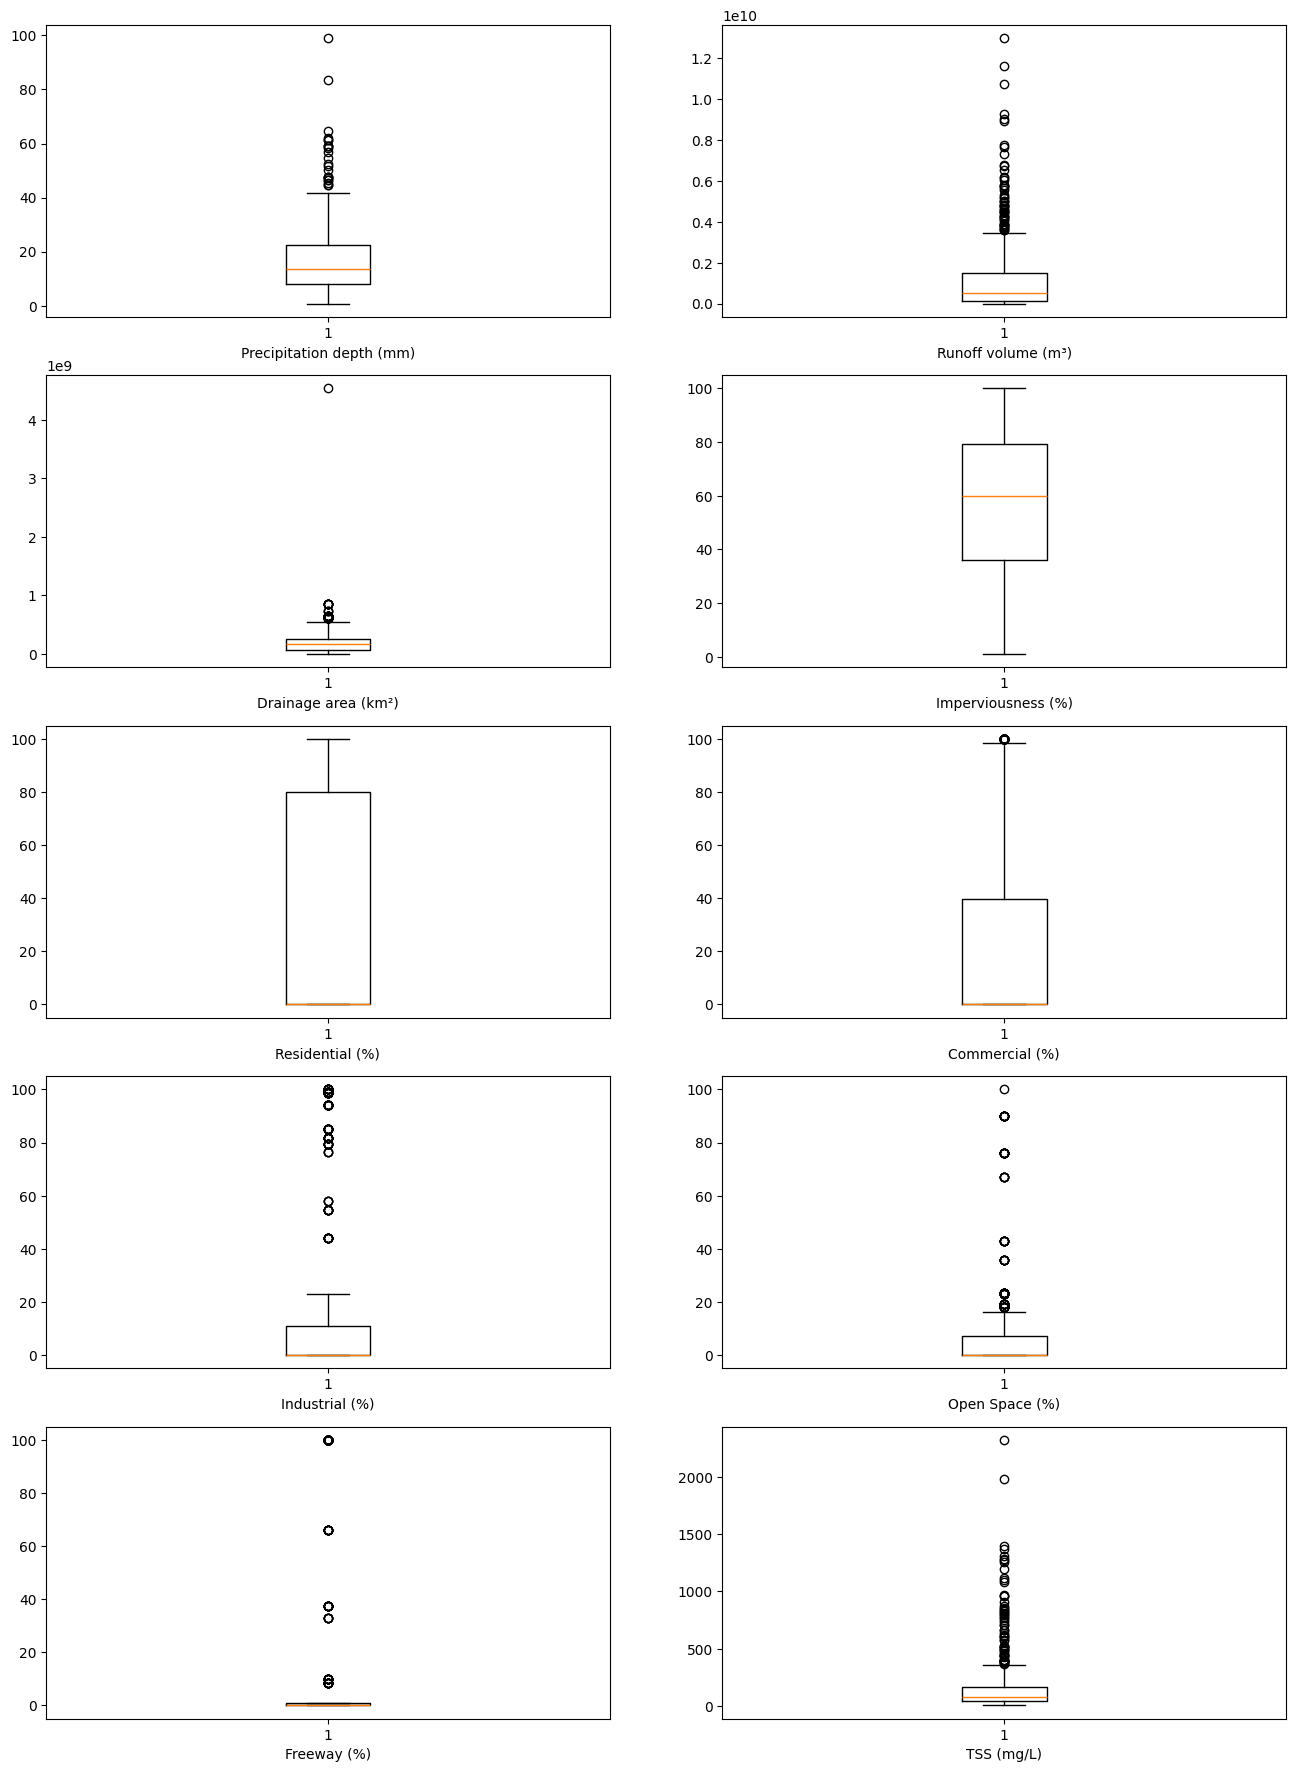

In [9]:
parameters = [
    'Precipitation depth (mm)',
    'Runoff volume (m³)',
    'Drainage area (km²)',
    'Imperviousness (%)',
    'Residential (%)',
    'Commercial (%)',
    'Industrial (%)',
    'Open Space (%)',
    'Freeway (%)',
]

target = 'TSS (mg/L)'


def boxplot(df: pd.DataFrame, cols: list[str], nrows: int = 5) -> None:
    ncols = len(cols) // nrows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 22))

    axes = axes.flatten()

    for i, col in enumerate(cols):
        axes[i].boxplot(df[col])
        axes[i].set_xlabel(col)


boxplot(df, parameters + [target])

Atestada a ocorrência destes seguimos a eliminar linhas cujos valores de TSS estão significativamete afastados da média (igual ou maior a quatro distâncias interquartis do terceiro quartil). Com isso reduzimos nosso número de observações para 532.

In [10]:
r = 4  # only exclude extreme outliers.
q1 = df[target].quantile(0.25)  # first quantile
q3 = df[target].quantile(0.75)  # third quantile
iqr = q3 - q1  # interquantile range

lower_bound = q1 - r * iqr
upper_bound = q3 + r * iqr

mask = (df[target] >= lower_bound) & (df[target] <= upper_bound)
df = df[mask]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532 entries, 219 to 8436
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EPA rain zone             532 non-null    Int64  
 1   Residential (%)           532 non-null    float64
 2   Commercial (%)            532 non-null    float64
 3   Industrial (%)            532 non-null    float64
 4   Open Space (%)            532 non-null    float64
 5   Freeway (%)               532 non-null    float64
 6   Imperviousness (%)        532 non-null    float64
 7   Main conveyance           415 non-null    object 
 8   Days since last rain      532 non-null    float64
 9   Season                    532 non-null    object 
 10  TSS (mg/L)                532 non-null    float64
 11  Drainage area (km²)       532 non-null    float64
 12  Precipitation depth (mm)  532 non-null    float64
 13  Runoff volume (m³)        532 non-null    float64
dtypes: Int64(1),

Em seguida, tendo em vista a aplicação de uma técnica de amostragem estratificada para validação cruzada (_Stratified K-Folds_), buscamos identificar todas as possíveis combinações de estações e zonas de chuva EPA. Espera-se que uma amostra suficiente e balanceada para treinamento do modelo contemple a todas as combinações descritas. Mas observa-se que a combinação da zona de chuva 9 com a estação primaveira contém apenas duas observações. Logo, estas observações também são descartadas no nosso modelo, e chegamos ao mesmo número de observações descrito pelos autores: 530.


Observations for each rain zone and season combination:
    EPA rain zone Season  Count
0               2     FA     32
1               2     SP     33
2               2     SU     44
3               2     WI     56
4               3     FA      6
5               3     SP      6
6               3     SU      6
7               3     WI     11
8               5     FA     47
9               5     SP     71
10              5     SU     10
11              5     WI     49
12              6     FA     22
13              6     SP     35
14              6     SU     14
15              6     WI     64
16              9     FA      4
17              9     SP      2
18              9     SU     20


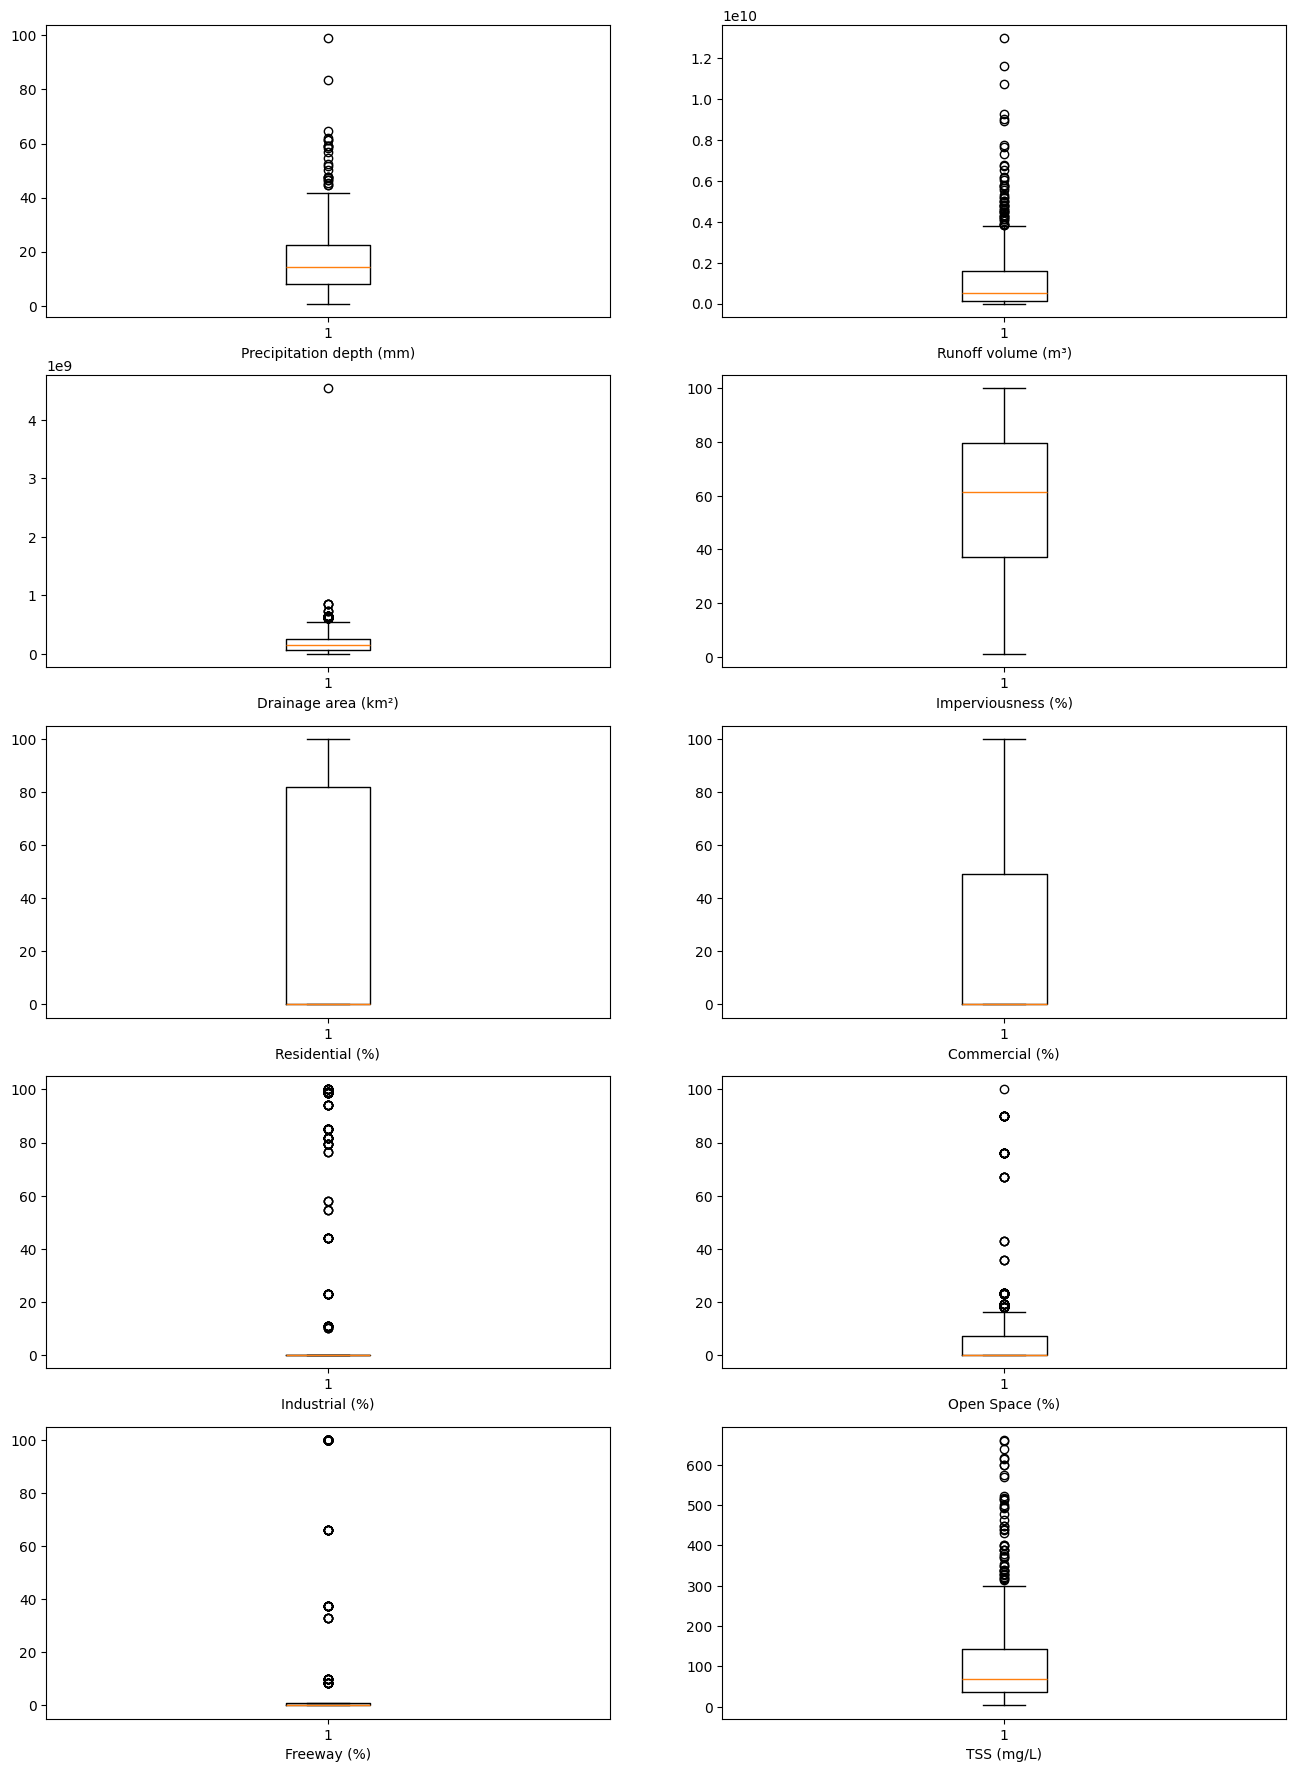

In [11]:
print("\nObservations for each rain zone and season combination:")
print(df.groupby(['EPA rain zone', 'Season']).size().reset_index(name='Count'))

mask = ~((df['EPA rain zone'] == 9) & (df['Season'] == 'SP'))
df = df[mask]
boxplot(df, parameters + [target])

## Regressão linear simples

A seguir executamos uma regressão linear simples para averiguar se uma correlação forte já é possível de ser atestada entre a variável alvo e algum dos parâmetros. Concluímos negativamente. Tidas individualmente, a variação do TSS é fracamente correlacionada (índice R² próximo de zero) a qualquer um dos parâmetros.


Precipitation depth (mm)
------------------------
                            OLS Regression Results                            
Dep. Variable:             TSS (mg/L)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07301
Date:                Sun, 14 Sep 2025   Prob (F-statistic):              0.787
Time:                        16:10:38   Log-Likelihood:                -3307.5
No. Observations:                 530   AIC:                             6619.
Df Residuals:                     528   BIC:                             6627.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

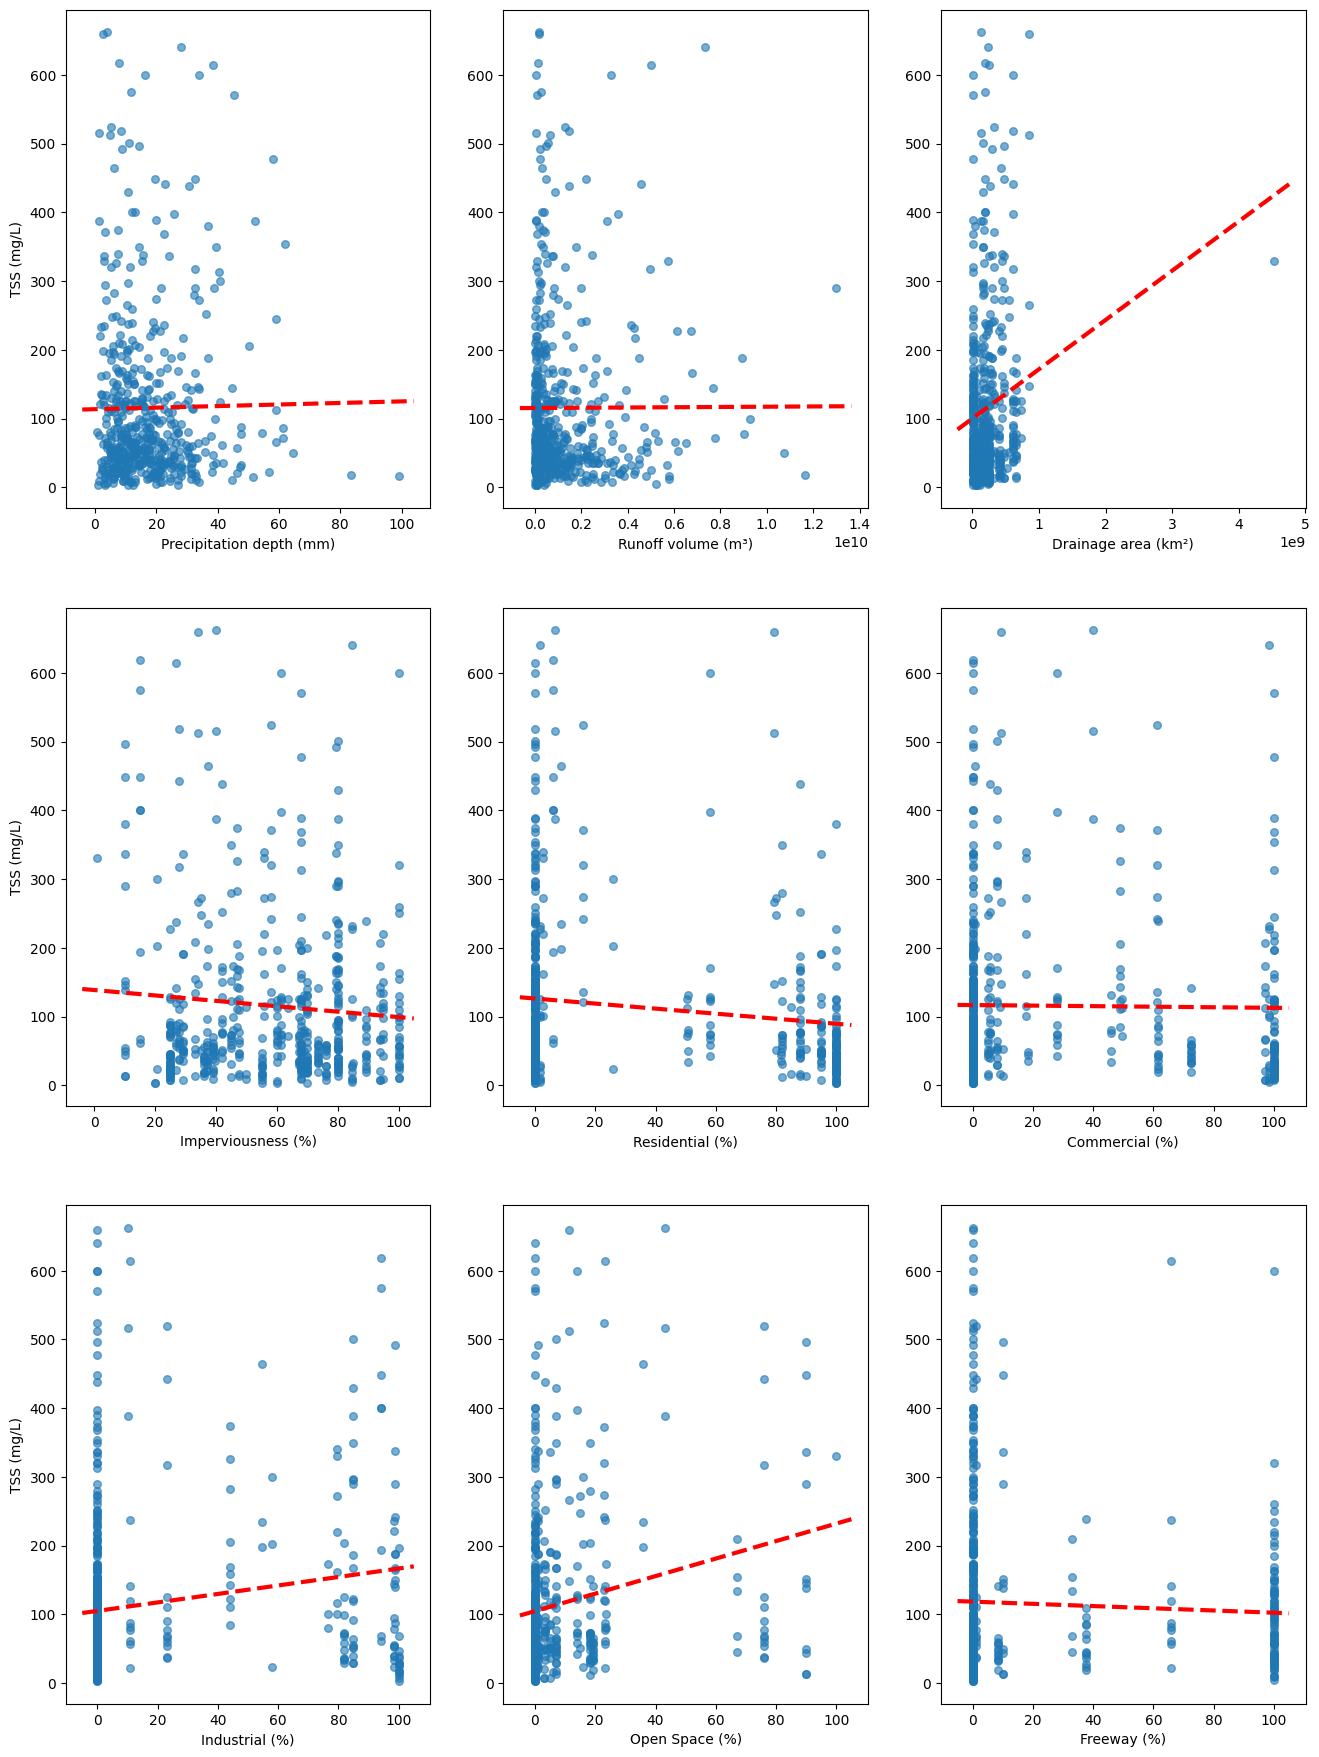

In [12]:
def plot_columns(
    df: pd.DataFrame,
    x_cols: list[str],
    y_col: str,
    y_label: str,
    func: Callable[[Axes, pd.Series | pd.DataFrame, pd.Series], None],
    nrows: int = 3,
) -> None:
    ncols = len(x_cols) // nrows
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 22))

    for i in range(nrows):
        k = i * ncols
        axs[i, 0].set_ylabel(y_label)
        func(axs[i, 0], df[x_cols[k]], df[y_col])
        for j in range(1, ncols):
            k += 1
            func(axs[i, j], df[x_cols[k]], df[y_col])


def simple_regression(x: pd.Series, y: pd.Series) -> RegressionResults:
    augumented_x = {'Intercept': np.ones(x.shape), 'Slope': x.to_numpy()}
    model = sm.OLS(y, pd.DataFrame(augumented_x, index=x.index))
    return model.fit()


def linear_regression(
    ax: Axes,
    x: pd.Series | pd.DataFrame,
    y: pd.Series,
    train_model: Callable[[pd.Series | pd.DataFrame, pd.Series], None],
) -> None:
    result = train_model(x, y)
    intercept = result.params.iloc[0]
    slope = result.params.iloc[1]
    print(f"\n{x.name}\n{"-" * len(x.name)}\n{result.summary()}")

    # Plot its results
    ax.scatter(x, y, alpha=0.6, marker='o', s=30)
    xlim = ax.get_xlim()
    ylim = [slope * xlim[0] + intercept, slope * xlim[1] + intercept]
    ax.plot(xlim, ylim, 'r--', linewidth=3)
    ax.set_xlabel(x.name)


plot_columns(
    df,
    parameters,
    target,
    target,
    partial(linear_regression, train_model=simple_regression)
)

In [13]:
# def regression_residuals(ax: Axes, x: pd.Series, y: pd.Series) -> None:
#     result = train_model(x, y)
#     ax.scatter(result.fittedvalues, result.resid)
#     ax.set_xlabel(f"{x.name}: Fitted Value")
#     ax.axhline(0, c='k', ls='--');


# plot_columns(df, columns, 'TSS (mg/L)', 'Residual', regression_residuals)

## Regressão linear múltipla

Em seguida buscamos correlacionar o TSS a variação de todos os parâmetros tidos em conjunto, em uma regressão linear múltipla. Treinamos o modelo em 2 terços das observações e o validamos na predição do terço das observações restantes, como proposto pelos autores. A amostragem dos conjuntos de treino e teste é feita de forma aleatória mas estratificada, para que estes possuam uma divisão proporcional das observações tidas em cada combinaçao de zona de chuva e estação do ano. Repetimos a esta amostragem 10 vezes para atestar o desvio padrão provocado pela mudança da amostragem.

In [14]:
def multiple_regression(x: pd.DataFrame, y: pd.Series) -> RegressionResults:
    model = sm.OLS(y, sm.add_constant(x, prepend=True))
    return model.fit()

def NSE(
    y_actual: list[float],
    y_predicted: list[float],
) -> float:
    """Calculates the Nash-Sutcliffe Efficiency."""
    numerator = np.sum((y_actual - y_predicted) ** 2)
    denominador = np.sum((np.mean(y_actual) - y_actual) ** 2)
    return 1 - (numerator / denominador)

X = df[parameters]
y = df[target]
stratification = df['Stratification Group'] = (
    df['EPA rain zone'].astype(str) + '_' + df['Season'].astype(str)
)
kf = RSKF(n_splits=3, random_state=42)

metrics = []
labels = [
    'R2_train',
    'R2_test',
    'RMSE_train',
    'RMSE_test',
    'NSE_train',
    'NSE_test',
]
predictions = {}

for i, (train_index, test_index) in enumerate(kf.split(X, stratification)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    multi = multiple_regression(X_train, y_train)
    y_train_predicted = multi.predict()
    y_test_predicted = multi.predict(sm.add_constant(X_test, prepend=True))

    # Store predictions aggregated by its observation ID
    for idx, prediction in zip(test_index, y_test_predicted):
        if idx not in predictions:
            predictions[idx] = []
        predictions[idx].append(prediction)

    # Store fitness metrics
    metrics.append(
        {
            'R2_train': r2_score(y_train, y_train_predicted),
            'R2_test': r2_score(y_test, y_test_predicted),
            'RMSE_train': np.sqrt(MSE(y_train, y_train_predicted) / len(y_train)),
            'RMSE_test': np.sqrt(MSE(y_test, y_test_predicted) / len(y_test)),
            'NSE_train': NSE(y_train, y_train_predicted),
            'NSE_test': NSE(y_test, y_test_predicted),
        }
    )

metrics_df = pd.DataFrame(metrics)
summary = metrics_df[labels].mean().to_frame().T
std_dev = metrics_df[labels].std().to_frame().T

# Print summary results for the train set
print("\n--- TRAIN SET METRICS (averaged across folds) ---")
print(f"R²: {summary['R2_train'].iloc[0]:.4f} ± {std_dev['R2_train'].iloc[0]:.4f}")
print(f"RMSE: {summary['RMSE_train'].iloc[0]:.4f} ± {std_dev['RMSE_train'].iloc[0]:.4f} (mg/L)")
print(f"NSE: {summary['NSE_train'].iloc[0]:.4f} ± {std_dev['NSE_train'].iloc[0]:.4f}")

# Print summary results for the test set
print("\n--- TEST SET METRICS (averaged across folds) ---")
print(f"R²: {summary['R2_test'].iloc[0]:.4f} ± {std_dev['R2_test'].iloc[0]:.4f}")
print(f"RMSE: {summary['RMSE_test'].iloc[0]:.4f} ± {std_dev['RMSE_test'].iloc[0]:.4f}  (mg/L)")
print(f"NSE: {summary['NSE_test'].iloc[0]:.4f} ± {std_dev['NSE_test'].iloc[0]:.4f}")


--- TRAIN SET METRICS (averaged across folds) ---
R²: 0.1218 ± 0.0244
RMSE: 6.1879 ± 0.1551 (mg/L)
NSE: 0.1218 ± 0.0244

--- TEST SET METRICS (averaged across folds) ---
R²: 0.0477 ± 0.0647
RMSE: 9.0972 ± 0.4150  (mg/L)
NSE: 0.0477 ± 0.0647


Em seguida desenhamos o gráfico de disperção do valor médio predito (nas 10 amostragens diferentes) e o valor real das observações. Temos um resultado bastante próximo àquele tido no artigo, ainda que com ligeira piora nas métricas de desempenho R², RMSE e NSE (que já não eram boas). Semelhante ao artigo original, nosso modelo consistentemente subestima o valor real do TSS.

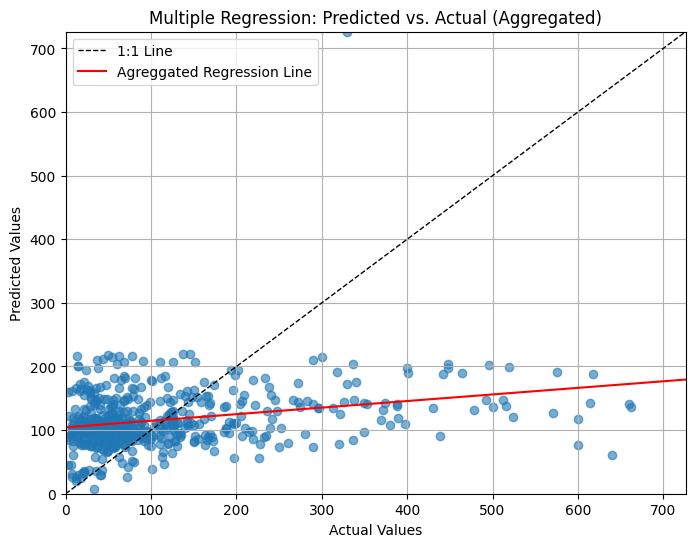

In [15]:
# Calculate the averaged predictions and collect the target values
averaged_predictions = []
actual_values = []

for idx, preds in predictions.items():
    averaged_predictions.append(np.mean(preds))
    actual_values.append(df.iloc[idx][target])

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, averaged_predictions, alpha=0.6)

# Add the 1:1 line for reference
max_val = max(max(actual_values), max(averaged_predictions))
plt.plot([0, max_val], [0, max_val], 'k--', linewidth=1, label='1:1 Line')

# Add the regression line for the aggregated results
z = np.polyfit(actual_values, averaged_predictions, 1)
p = np.poly1d(z)
x_for_line = np.linspace(0, max_val, 100)
plt.plot(x_for_line, p(x_for_line), "r-", label=f'Agreggated Regression Line')

# Set plot labels and title
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Multiple Regression: Predicted vs. Actual (Aggregated)")
plt.legend()
plt.grid(True)
plt.show()